# Handout #2: Instance-based Learning

## Problem 1

### Apartat (a)

Given dataset `ds012.txt`:

a) Mapping the training samples onto an alternative 2-dimensional space using 
$\Phi(x_1, x_2) = (x_1 x_2, x_1^2 + x_2^2)$,
solve for the SVM analytically using a quadratic programming solver and
1. find and report the *support vectors* *in the **original space*** 
(NOTE: due to round-off errors, it is likely
none of the $\lambda_i$ are exactly 0, but close, e.g. $10^{−6}$); and
2. calculate and report the resulting *decision function* both in the transformed space 
$g_1(x') = w^T x' + w_0 [x' = \Phi(x)]$ 
and in the original space $g_2(x) = w^T \Phi(x) + w_0$

### Resposta apartat (a)

#### Punt a.1

Dades d'identificació:

In [1]:
group = '01' # assuming group 1
ds = 2 # assuming problem 2

In [2]:
# Definim un número molt proper a zero 
# per redefinir els paràmetres lambda com a zero 
# quan siguin menors de epsilon

epsilon = 1e-6

# També parametritzam el valor de les classes

cl_w1_value = +1
cl_w2_value = -1

cl_w1_color = '+r'
cl_w2_color = '+g'

Importam llibreries

In [3]:
import numpy as np

Carregam dades del problema

In [4]:
# Aquesta funció ens farà més fàcil carregar les matrius

def load_data(group: str, problem: int):
    
    # carregam fitxer del dataset
    data = np.loadtxt('datasets'+group+'/ds'+group+str(ds)+'.txt')
    # matriu de vectors
    X = data[:, 0:2]
    # vector de classes
    y = data[:, 2:3]
    
    # les classes han de ser -1 i +1
    # per tant si ens ho passen com a 0 i 1 ho transformam
    if np.any(y == 0):
        y = 2 * y - 1
        
    return X, y

In [5]:
# Carregam 

X, y = load_data(group, ds)

print(X.shape, y.shape)

(32, 2) (32, 1)


In [6]:
# N és el número de vectors

N = X.shape[0]
N

32

Definim algunes funcions que ens ajudaran a dibuixar la constel·lació

In [7]:
def get_c_index(vector: np.ndarray, cl_value: int) -> list: 
    
    if not isinstance(vector, np.ndarray):
        raise ValueError('El paràmetre vector ha de ser de tipus np.ndarray')
    if not isinstance(cl_value, int):
        raise ValueError('El paràmetre cl_value ha de ser de tipus enter')
        
    index = []
    for i in range(vector.shape[0]): 
        if vector[i] == cl_value: 
            index.append(i)
    
    return index

In [8]:
import matplotlib.pyplot as plt

def plot_points(X, y):
    
    cl_w1_index = get_c_index(y, cl_w1_value)
    cl_w2_index = get_c_index(y, cl_w2_value)

    ## començam a dibuixar
    ##
    plt.figure(1)

    ## dibuixam els punts per cada classe
    ##
    plt.plot(X[cl_w1_index, 0], X[cl_w1_index, 1], cl_w1_color) # class w1
    plt.plot(X[cl_w2_index, 0], X[cl_w2_index, 1], cl_w2_color) # class w2

    ## format
    ##
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)

    return

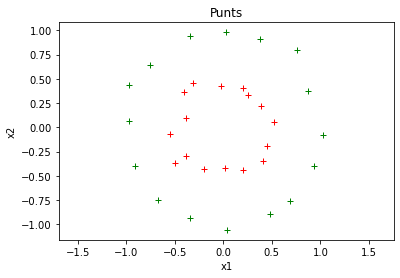

In [9]:
plot_points(X, y)

Vaja, sembla que estam davant un **cas de no linealitat**

Per tal de passar a una nou espai, definim la funció 
$\Phi(x_1, x_2)=(x_1 x_2, x_1^2 + x_2^2)$

La farem servir per a canviar d'espai i convertir aquest problema 
en un problema linealment separable

In [10]:
def phi(X):
    
    return np.vstack((X[:, 0] * X[:, 1], X[:, 0] * X[:, 0] + X[:, 1] * X[:, 1])).T

In [11]:
X_trans = phi(X)
X_trans

array([[ 0.34648833,  0.96764008],
       [ 0.03860235,  0.303081  ],
       [ 0.32763657,  0.89788854],
       [ 0.03063328,  0.27239467],
       [-0.08412346,  1.07084099],
       [-0.14345607,  0.29126741],
       [-0.48874978,  0.98947632],
       [-0.14014824,  0.30198011],
       [-0.52360039,  1.05205144],
       [-0.37234231,  1.03261038],
       [-0.08555845,  0.23933256],
       [ 0.32331348,  0.99559654],
       [ 0.02258319,  0.95958436],
       [-0.01130112,  0.18464081],
       [ 0.08748224,  0.22618607],
       [ 0.50038937,  1.00595292],
       [ 0.60696537,  1.21487467],
       [ 0.11478483,  0.23816458],
       [-0.00794429,  0.1764585 ],
       [-0.14826954,  0.29791109],
       [ 0.08392342,  0.17497222],
       [ 0.08453322,  0.19616107],
       [-0.08796035,  0.23075377],
       [-0.06013565,  0.94134823],
       [-0.03824405,  1.11735654],
       [-0.42409856,  1.02003836],
       [-0.03794782,  0.15659263],
       [-0.41730921,  1.12164731],
       [ 0.36547264,

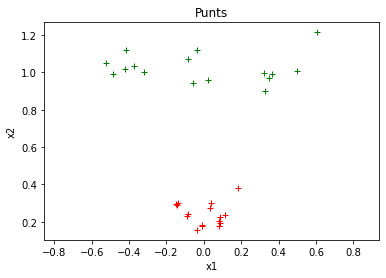

In [12]:
plot_points(X_trans, y)

Definim una funció per a calcular la matriu $H$

In [13]:
def build_H(X: np.array, y: np.array):
    
    P = np.multiply(np.dot(y, y.T), np.dot(X, X.T))

    return P

In [14]:
# Calculam la matriu dels productes creuats

P = build_H(X_trans, y)
P

array([[ 1.05638149, -0.30664858,  0.98235519, ..., -0.2244948 ,
         0.85828669, -0.43076586],
       [-0.30664858,  0.09334823, -0.2847805 , ...,  0.06470615,
        -0.29127105,  0.12219207],
       [ 0.98235519, -0.2847805 ,  0.91354955, ..., -0.2088036 ,
         0.79445217, -0.40082955],
       ...,
       [-0.2244948 ,  0.06470615, -0.2088036 , ...,  0.04775703,
        -0.1779192 ,  0.09184646],
       [ 0.85828669, -0.29127105,  0.79445217, ..., -0.1779192 ,
         1.10682849, -0.32226915],
       [-0.43076586,  0.12219207, -0.40082955, ...,  0.09184646,
        -0.32226915,  0.1775318 ]])

In [15]:
# Calculam els vectors del sistema a resoldre 
# (que ha generat la funció Lagrangiana)

q = -np.ones((N,))
G = -np.identity(N)
h = np.zeros((N,))
A = y.reshape((1,-1))
b = np.zeros(1)

In [16]:
# Importam la funció que ho soluciona (ho fa cridant a cxvopt)

from qpsolvers import solve_qp

# Cridam al solucionador del sistema lineal

lm = solve_qp(P, q, G, h, A, b, solver = 'cvxopt')

# Miram quins paràmetres ens ha retornat
lm

array([3.16918136e-08, 2.37298787e-08, 5.51413383e+00, 1.80786491e-08,
       1.81827712e-08, 1.77072147e-08, 1.96688766e-05, 1.92109984e-08,
       3.81868932e-08, 4.01610199e-08, 1.33446630e-08, 2.36075595e-08,
       8.25800384e-08, 1.05896639e-08, 1.38963539e-08, 1.80986895e-08,
       6.67617586e-09, 1.52617176e-08, 1.02295078e-08, 1.84920697e-08,
       1.06438856e-08, 1.17817486e-08, 1.27150561e-08, 1.58163679e+00,
       1.29537460e-08, 5.78970061e-08, 9.28633159e-09, 1.64167183e-08,
       2.37012661e-08, 1.21867782e-08, 6.97940997e-08, 7.09579052e+00])

In [17]:
# Definim una funció per posar a zero els valors molt petits
# Aquests quasi-zeros es produeixen per mor de la precissió de càlcul, 
# però en realitat, en el nostre cas, haurien de de ser zeros

import numpy as np 

def epsilize(vector: object, eps: float = 1e-6, target: float = 0.) -> np.ndarray:
    
    if not isinstance(eps, float):
        raise ValueError('El paràmetre eps (epsilon) ha de ser de tipus float')
        
    if not isinstance(target, float):
        raise ValueError('El paràmetre target ha de ser de tipus float')
        
    if isinstance(vector, np.ndarray):
        for i in range(vector.shape[0]): 
            if np.abs(target - vector[i]) < eps: 
                vector[i] = target
    elif isinstance(vector, float):
        if np.abs(target - vector) < eps:
            vector = target
    else:
        raise ValueError('El paràmetre vector ha de ser de tipus np.ndarray o un sol valor float')

    return vector

In [18]:
# Netejam a la matriu els valors quasi nuls

lm = epsilize(lm, eps = 1e-6)

lm

array([0.00000000e+00, 0.00000000e+00, 5.51413383e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.96688766e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.58163679e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.09579052e+00])

Ara que ja tenim el multiplicadors de KKT, $\lambda_i$, 
podem saber quin són els nostres vectors de suport. 
Per a fer-ho cream una funció que ens ajudi:

In [19]:
import numpy as np

def get_sv_index(vector: np.ndarray) -> list: 
    
    if not isinstance(vector, np.ndarray):
        raise ValueError('El paràmetre vector ha de ser de tipus np.ndarray')
        
    index = []
    for i in range(vector.shape[0]): 
        if vector[i] != 0: 
            index.append(i)
    
    return index

Aquesta és la ubicació dins la matriu de vectors que ocupen els 
punts que són vectors de suport:

In [20]:
sv_index = get_sv_index(lm)
sv_index

[2, 6, 23, 31]

#### Resultat punt a.1

I aquests són els vectors de suport del nostre conjunt
a **l'espai original**:

In [21]:
sv = X[sv_index]
sv

array([[ 0.86940956,  0.37684951],
       [-0.75596376,  0.64652541],
       [-0.96824109,  0.06210814],
       [-0.49423371, -0.36838816]])

---

#### Punt a.2

Al següent punt ens demanen 
que calculem quina és la funció de decisió.
$$g(x) = w^T \cdot x + w_0$$

A l'espai transformat i a l'espai original.

On $w$ és la següent combinació lineal:
$$w = \sum_{i | \lambda_i \ne 0}{\lambda_i y_i x_i}$$

I $w_0$ es calcula com el promig de tots els seus valors possibles
per tal de mitigar els errors en precisió:
$$w_0 = \frac{1}{N_\lambda} \sum_{i | \lambda_i \ne 0}{\left( y_i - w^T x_i \right)}$$
O de forma equivalent:
$$w_0 = \frac{1}{N_\lambda} \left[ \sum_{i | \lambda_i \ne 0}{y_i} - \sum_{i,j | \lambda_i, \lambda_j \ne 0}{\lambda_j y_j x_j^T x_i} \right]$$

Definirem dues funcions per encapsular els càlculs:

In [22]:
import numpy as np

def get_w(lamb, y, X: np.ndarray) -> np.ndarray: 
    
    if not isinstance(lamb, np.ndarray):
        raise ValueError('lamb (vector de multiplicadors de KKT) ha de ser de tipus np.ndarray')
    if not isinstance(y, np.ndarray):
        raise ValueError('y (vector dels indicadors de classe) ha de ser de tipus np.ndarray')
    if not isinstance(X, np.ndarray):
        raise ValueError('X (matriu de punts) ha de ser de tipus np.ndarray')
        
    w = np.zeros(X.shape[1])
    for i in get_sv_index(lamb): 
        w += lamb[i] * y[i] * X[i]
    
    return w

In [23]:
import numpy as np

def get_w0(lamb, y, X: np.ndarray) -> float: 
    
    if not isinstance(lamb, np.ndarray):
        raise ValueError('lamb (vector de multiplicadors de KKT) ha de ser de tipus np.ndarray')
    if not isinstance(y, np.ndarray):
        raise ValueError('y (vector dels indicadors de classe) ha de ser de tipus np.ndarray')
    if not isinstance(X, np.ndarray):
        raise ValueError('X (matriu de punts) ha de ser de tipus np.ndarray')
    
    lambs_index = get_sv_index(lamb)
    # N_lambda
    n_lambs = len(lambs_index)
    
    if n_lambs == 0: raise ValueError('el número de multiplicadors no pot ser zero')

    sum1 = np.sum(y[lambs_index])

    sum2 = 0
    for i in lambs_index:
        for j in lambs_index:
            sum2 += lamb[j] * y[j] * float(np.dot(X[j].T, X[i]))


    w0 = (sum1 - sum2) / n_lambs

    return w0

#### Resultat punt a.2

Ens demanen que cerquem les dues funcions de decisió: 

Espai transformat: $$g_1(x') = w^T x' + w_0' [x' = \Phi(x)]$$

Espai original: $$g_2(x) = w^T x + w_0$$

Definim una funció genèrica, que ens servirà com a primitiva de les dues que cercam:

In [24]:
def g_func(x, w: np.ndarray, w0: float) -> np.ndarray:
    
    return np.dot(w.T, x) + w0

I calculam els coeficients i el terme independent per a cada cas:

In [25]:
w_trans = get_w(lm, y, X_trans)
w_trans

array([-0.41958002, -3.74373229])

In [26]:
w0_trans = get_w0(lm, y, X_trans)
w0_trans

array([2.4990093])

Per tant la funció de decisió a l'espai transformat serà:

In [27]:
# Funció de decisió  l'espai transformat

def g1(x):
    
    return g_func(x, w_trans, w0_trans)

La provam i aprofitam la nostra funció `epsilize` per arrodonir 
el valor dels punts que cauen a prop del llindar de decisió.
Així és més fàcil confirmar si hi ha vectors de suport degenerats
(vectors en el llindar de decisió 
però que no cal tenir en compte per a la determinació de l'hiperplà):

In [28]:
def bound(x, eps): 
    return epsilize(epsilize(x, eps, target = 1.), eps, target = -1.)

def print_g(g, X, y, eps = 1e-6):
    n_errors = 0
    for i in range(X.shape[0]):
        print(f"g1(x{i:2}) = {bound(g(X[i]), eps).item():+.8f}"
              f"  y({i:2}) = {y[i].item():+1}")
        if np.sign(g(X[i]).item()) * y[i].item() == -1:
            n_errors += 1
    print(f"\nErrors de classificació: {n_errors}")
    
    return

# Utilitzam una tolerància de 10^-3 per tal de poder arrodonir 
# el valor de g(x) quan x és un vector de suport
print_g(g1, X_trans, y, 1e-3)

g1(x 0) = -1.26895569  y( 0) = -1.0
g1(x 1) = +1.34815841  y( 1) = +1.0
g1(x 2) = -1.00000000  y( 2) = -1.0
g1(x 3) = +1.46638348  y( 3) = +1.0
g1(x 4) = -1.47463616  y( 4) = -1.0
g1(x 5) = +1.46877338  y( 5) = +1.0
g1(x 6) = -1.00000000  y( 6) = -1.0
g1(x 7) = +1.42728000  y( 7) = +1.0
g1(x 8) = -1.21989738  y( 8) = -1.0
g1(x 9) = -1.21058014  y( 9) = -1.0
g1(x10) = +1.63891087  y(10) = +1.0
g1(x11) = -1.36389348  y(11) = -1.0
g1(x12) = -1.10289312  y(12) = -1.0
g1(x13) = +1.81250525  y(13) = +1.0
g1(x14) = +1.61552340  y(14) = +1.0
g1(x15) = -1.47696251  y(15) = -1.0
g1(x16) = -2.30382677  y(16) = -1.0
g1(x17) = +1.55922346  y(17) = +1.0
g1(x18) = +1.84172919  y(18) = +1.0
g1(x19) = +1.44592088  y(19) = +1.0
g1(x20) = +1.80874756  y(20) = +1.0
g1(x21) = +1.72916634  y(21) = +1.0
g1(x22) = +1.67203537  y(22) = +1.0
g1(x23) = -1.00000000  y(23) = -1.0
g1(x24) = -1.66802803  y(24) = -1.0
g1(x25) = -1.14179795  y(25) = -1.0
g1(x26) = +1.92869055  y(26) = +1.0
g1(x27) = -1.52504334  y(27)

Comprovam que la funció $g_1(x)$ (espai transformat) està classificant correctament.

> **Nota :** Per tal de visibilitzar els vectors de suport, hem hagut de fer servir la **tolerància 1e-3**,
bastant més elevada que la original 1e-6. 
Suposam que és per mor de la precisió numèrica de *Python*.

In [29]:
w = get_w(lm, y, X)
w

array([-6.76959894, -4.79024911])

In [30]:
w0 = get_w0(lm, y, X)
w0

array([-1.92433053])

Per tant la funció de decisió a l'espai original serà:

In [31]:
# Funció de decisió a l'espai original

def g2(x):
    
    return g_func(x, w, w0)

In [32]:
print_g(g2, X_trans, y)

g1(x 0) = -8.90515458  y( 0) = -1.0
g1(x 1) = -3.63748642  y( 1) = +1.0
g1(x 2) = -8.44340849  y( 2) = -1.0
g1(x 3) = -3.43654383  y( 3) = +1.0
g1(x 4) = -6.48444356  y( 4) = -1.0
g1(x 5) = -2.34843391  y( 5) = +1.0
g1(x 6) = -3.35552857  y( 6) = -1.0
g1(x 7) = -2.42214309  y( 7) = +1.0
g1(x 8) = -3.41935438  y( 8) = -1.0
g1(x 9) = -4.35018336  y( 9) = -1.0
g1(x10) = -2.49159671  y(10) = +1.0
g1(x11) = -8.88218854  y(11) = -1.0
g1(x12) = -6.67385779  y(12) = -1.0
g1(x13) = -2.73230200  y(13) = +1.0
g1(x14) = -3.60003785  y(14) = +1.0
g1(x15) = -10.13053096  y(15) = -1.0
g1(x16) = -11.85279494  y(16) = -1.0
g1(x17) = -3.84224545  y(17) = +1.0
g1(x18) = -2.71583103  y(18) = +1.0
g1(x19) = -2.34767354  y(19) = +1.0
g1(x20) = -3.33061893  y(20) = +1.0
g1(x21) = -3.43624692  y(21) = +1.0
g1(x22) = -2.43424228  y(22) = +1.0
g1(x23) = -6.02652881  y(23) = -1.0
g1(x24) = -7.01784985  y(24) = -1.0
g1(x25) = -3.93959123  y(25) = -1.0
g1(x26) = -2.41755673  y(26) = +1.0
g1(x27) = -4.47228459  y(2

---

### Apartat (b)

b) Generate the following plots:
1. a first plot with the *training samples* 
in the *transformed space*,
highlighting the *support vectors* 
and plotting the 2D *decision curve*;
2. a second plot with the *training samples* 
in the *original space*,
highlighting the *support vectors* 
and plotting the 2D *decision curve*; and
3. a third plot with the *classification map* **in the *original space***, 
i.e. evaluate the decision function 
for a ’regular’ subset (grid)
of points.

Use different markers and/or colours for each class. See the appendix for examples of the requested plots

### Resposta apartat (b)

Per a fer el diagrames serà pràctic crear una funció 
que ens ajudi a confeccionar les llistes dels components de cada classe:

In [33]:
cl_w1_index = get_c_index(y, cl_w1_value)

cl_w1_index

[1, 3, 5, 7, 10, 13, 14, 17, 18, 19, 20, 21, 22, 26, 29, 31]

In [34]:
cl_w2_index = get_c_index(y, cl_w2_value)

cl_w2_index

[0, 2, 4, 6, 8, 9, 11, 12, 15, 16, 23, 24, 25, 27, 28, 30]

#### Resultat punt b.1

Definim algunes funcions necessàries per a fer els diagrames.

In [35]:
import numpy as np

def get_view_limits(X: np.ndarray):
    
    ### límits del diagrama:
    x_left = np.floor(np.amin(X, axis = 0)[0])
    x_right = np.ceil(np.amax(X, axis = 0)[0])
    y_top = np.ceil(np.amax(X, axis = 0)[1])
    y_bottom = np.floor(np.amin(X, axis = 0)[1])
    
    return x_left, x_right, y_bottom, y_top


def get_mesh(g_func, 
             x_left: float, x_right: float, y_bottom: float, y_top: float, 
             res: int = 100):

    # calcula malla
    
    xx = np.linspace(x_left, x_right, res)
    yy = np.linspace(y_bottom, y_top, res)
    XX, YY = np.meshgrid(xx, yy, indexing = 'ij')
    Z = np.zeros((res * res, 1))

    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = g_func((x1, x2))
            k += 1

    return XX, YY, Z

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_contour(X: np.ndarray, y: np.ndarray, sv: list, 
                         g_func):
    
    # plot samples, highlighting some of them

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_w1_index = get_c_index(y, cl_w1_value)
    cl_w2_index = get_c_index(y, cl_w2_value)

    ## començam a dibuixar
    ##
    plt.figure(1)


    ## dibuixam la corba de decisió i els marges
    ##
    ax = plt.gca()
    ax.contour(XX, YY, Z.reshape(XX.shape), 
               colors='k',levels=[-1, 0, 1],alpha=0.5,linestyles=['--', '-', '--'])

    ## dibuixam els punts per cada classe
    ##
    plt.plot(X[cl_w1_index, 0], X[cl_w1_index, 1], cl_w1_color) # class w1
    plt.plot(X[cl_w2_index, 0], X[cl_w2_index, 1], cl_w2_color) # class w2
    hil = sv # samples to highlight

    ## i remarcam els vectors de suport
    ##
    ax2 = plt.gca()
    ax2.scatter(X[hil, 0], X[hil, 1], s = 100, 
               linewidth = 1, facecolors = 'none', edgecolors = 'k')

    ## format
    ##
    plt.xlim([x_left, x_right])
    plt.ylim([y_bottom, y_top])
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts, vectors de suport i corba de decisió amb marges')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_map_plane(X: np.ndarray, y: np.ndarray, sv: list, 
                   g_func): 
    
    # matrix-based predicate evaluation

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_w1_index = get_c_index(y, cl_w1_value)
    cl_w2_index = get_c_index(y, cl_w2_value)

    ## començam a dibuixar
    ##
    plt.figure(1)

    ## cream paleta de colors
    ##
    cl_w1_hex_color = '#b01010'  # red
    cl_w2_hex_color = '#408030'  # green 
    paleta = col.LinearSegmentedColormap.from_list(
        'SVM_2', [cl_w2_hex_color, cl_w1_hex_color])

    ## reduïm a només dues classes
    ##
    C = np.where(Z >= 0, 1, -1)

    ## cream mapa i llegenda
    ##
    plt.imshow(
        C.reshape(XX.shape).T, 
        origin = 'lower', 
        extent = (x_left, x_right, y_bottom, y_top), 
        cmap = paleta)
    plt.colorbar()
    
    ## format
    ##
    plt.title("Mapa de l'avaluació de la funció de classificació")
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.axis('equal')
    
    ## mostram
    ##
    plt.show(block=False) # to force visualization

    ## també dibuixarem el plànol en 3D
    ##
    plt.figure(2)
    ax = plt.axes(projection='3d')
    
    ax.plot_surface(XX, YY, Z.reshape(XX.shape), 
                    rstride = 1, cstride = 1, 
                    cmap = paleta, 
                    edgecolor = 'none')
    
    ## ajustam l'àngle per veure'l millor
    ##
    ax.view_init(45, -60)

    ## etiquetam el que manca i llest
    ##
    plt.title('Pla divisor')

    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

Anem a fer el primer diagrama:

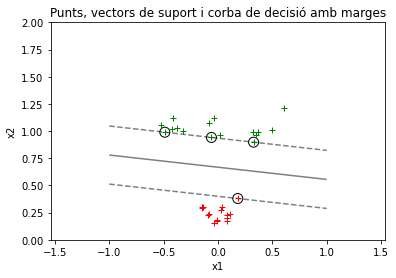

In [38]:
plot_scatter_contour(X_trans, y, sv_index, g1)

#### Resultat punt b.2

El segon mapa seria aquest:

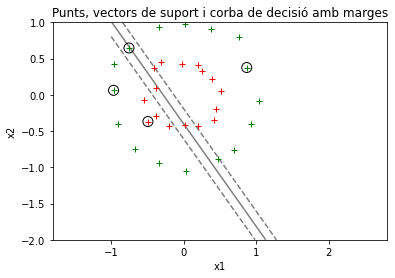

In [47]:
plot_scatter_contour(X, y, sv_index, g2)

#### Resultat punt b.3

Anem a fer el tercer diagrama, un mapa de les regions:

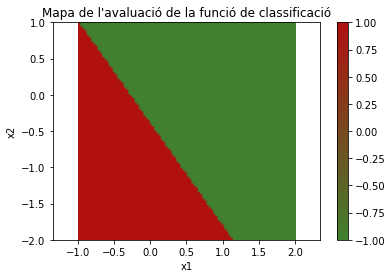

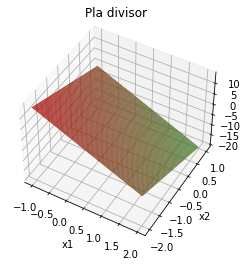

In [49]:
plot_map_plane(X, y, sv_index, g2)

### Apartat (c)

c) Compare the results obtained with the ones resulting from the `scikit-learn SVC` 
object: i.e. report the *support vectors* returned 
by `SVC` and the corresponding *decision function*, 
and provide the same kind of
plots requested before.

> NOTE: the SVC object solves the soft-margin kernel-based 
problem, hence you will have to 
supply the kernel specified in 
a) –use either `kernel = ’precomputed’` and compute the *gram matrix*, 
or supply a *callable* kernel when invoking the `SVC` object constructor– and 
set constant C with a high value, e.g. $10^{16}$, to force a perfect classification of the training set.

In [32]:
from sklearn import svm

clf = svm.SVC(C = 1e16, kernel = 'linear')
clf.fit(X, y.reshape((N,)))

sk_sv_index = list(clf.support_)
sk_sv = clf.support_vectors_
sk_w = clf.coef_.flatten()
sk_w0 = clf.intercept_.flatten()

In [33]:
sk_sv_index

[0, 8, 11]

In [34]:
sk_sv

array([[-1.935394  , -0.50423215],
       [ 1.9761613 , -3.61867192],
       [ 1.935394  ,  0.50423215]])

In [35]:
sk_w

array([0.51527214, 0.00509501])

In [36]:
w - sk_w

array([9.08605815e-05, 8.97401563e-07])

In [37]:
sk_w0

array([5.87752244e-05])

In [38]:
w0 - sk_w0

array([-5.87692545e-05])

Hi ha petites diferències dels valors. 
Segurament *sci-kit* obté el càlcul de forma distinta 
al que hem fet, 
o el paràmetre C no és prou gran.

In [39]:
for i in range(X.shape[0]):
    print(f"g(x{i}) = {bound(g_func(X[i], sk_w, sk_w0), 1e-3)}") # hem hagut d'utilitzar eps = 1e-3 en lloc de 1e-6

g(x0) = [-1.]
g(x1) = [-2.49950041]
g(x2) = [-2.37452245]
g(x3) = [-1.99958857]
g(x4) = [-1.37469878]
g(x5) = [-1.37469878]
g(x6) = [-1.74963265]
g(x7) = [-1.12474286]
g(x8) = [1.]
g(x9) = [1.99970612]
g(x10) = [1.74975021]
g(x11) = [1.]
g(x12) = [1.37481633]
g(x13) = [1.12486041]
g(x14) = [1.37481633]
g(x15) = [1.24983837]


Vaja, hem hagut de pujar el valor de épsilon tres ordres de magnitud
per poder arrodonir el resultat de la funció quan l'argument 
és un vector de suport. 

Això **ens fa pensar que la precisió obtinguda solucionant
el sistema d'equacions és superior a la del mètode de *sci-kit***. 

Anem a veure com surten els diagrames:

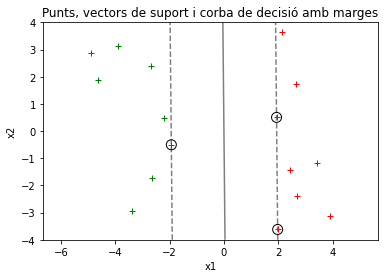

In [40]:
plot_scatter_contour(X, y, sk_sv_index, g_func, sk_w, sk_w0)

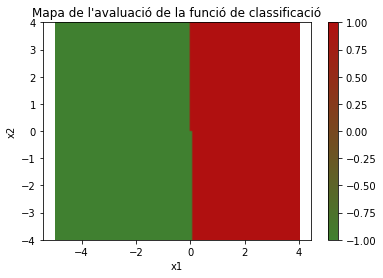

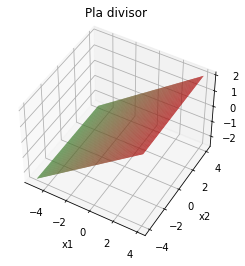

In [41]:
plot_map_plane(X, y, sk_sv_index, g_func, sk_w, sk_w0)

Les representacions **semblen visualment idèntiques** a les del primer mètode.

### Apartat (d)

d) Also by means of the `scikit-learn SVC` object, repeat point c) 
for the `’rbf’p` kernel (γ = 1). 
Additionally, draw the corresponding RBF network (slide 42 of the SVM lecture notes), 
replacing $K(x_i, x)$, $\lambda_i$ and $y_i$ by your values.

## Conclusions

En aquest problema hem vist dos mètodes per a determinar 
els vectors de suport, la funció de decisió i per tant també les regions 
i hiperplans de les màquines de vectors de suport. 
En ambdós casos hem mostrat els resultats numèrics 
i algunes representacions.

La determinació de màquines de vectors de suport 
mitjanant la classe `SVC` del mòdul `svm` de la llibreria `sklearn` 
és més senzilla que 
fent-ho de forma analítica, 
resolvent el sistema que resulta de l'aplicació 
de les condicions Karush-Kuhn-Tucker 
i la representació dual de Wolfe. 

Comparant la distància entre els vectors de suport
i el llindar teòric de decisió en ambdues solucions, 
veim que la distància és més gran en el cas del mètode `SVC`, 
el que ens fa pensar que la precisió obtinguda en el càlcul 
dels vectors de coeficients i de la intercepció
amb aquest mètode 
és més baixa comparada amb l'obtinguda pel mètode analític. 

A nivell de les diferents representacions. no apreciam diferències. 

Malgrat la precisió obtinguda per `SVC` és inferior 
a l'obtinguda resolent el sistema de la forma analítica, 
aquesta sembla ser més que suficient 
per no classificar malament un element, 
pensam per tant que el mètode de càlcul de la classe `SVC`
és adeqüat per a la majoria d'aplicacions i té l'avantatge 
de tenir una interfície més simple.